<img src="gval_light_mode.png" style="float:left">

In [1]:
import rioxarray as rxr
import gval

## Load Datasets

It is preferred to use masking and scaling by default.  If your original data does not have nodata or does not have nodata assigned, please assign using: `rio.set_nodata(<your_nodata_value>)`

In [2]:
candidate = rxr.open_rasterio('candidate_map_two_class_categorical.tif', mask_and_scale=True)
benchmark = rxr.open_rasterio('benchmark_map_two_class_categorical.tif', mask_and_scale=True)

## Run GVAL Categorical Compare

An example of running the entire process with one command using minimal arguments is deomnstrated below.

In [3]:
agreement_map, crosstab_table, metric_table = candidate.gval.categorical_compare(benchmark,
                                                                                 positive_categories=[2],
                                                                                 negative_categories=None)

## Output

#### Agreement Map

The agreement map compares the encodings of the benchmark map and candidate map using a "comparison function" to then output unique encodings.  In this particular case the "Szudzik" comparison function was used by default since no argument was passed in for the `comparison_function` argument.  The Szudzik function is defined below:

$
c = \text{candidate value} \\
b = \text{benchmark value} \\
f(x)= 
\begin{cases}
    c^{2} + c + b,& \text{if } c\geq b\\
    b^{2} + c,              & \text{otherwise}
\end{cases}$


The resulting map allows a user to visualize these encodings as follows:

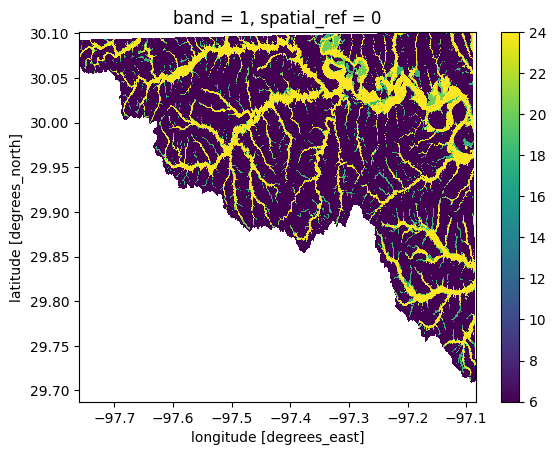

In [4]:
agreement_map.plot()

#### Cross-tabulation Table

A cross-tabulation table displays the frequency of each class in the presence of another within the spatial unit of interest. (In this case a pixel in each raster dataset.)  This can then be used to compute categorical statistics.

In [5]:
crosstab_table

,band,candidate_values,benchmark_values,counts,conditions
0,1,1.0,0.0,10345720.0,None
1,1,2.0,0.0,512277.0,fp
2,1,1.0,2.0,639227.0,fn
3,1,2.0,2.0,2473405.0,tp


#### Metric Table

A metric table contains information about the unit of analysis, (a single band in this case), and selected categorical statistics.  This is done by specifying the positive and negative categories of each dataset and then choosing the statistics of interest.  Since we did not provide the `metrics` argument GVAL computed all of the available categorical statistics.  (<b>Note: if there is no negative class encoding all statistics computing negatives will be skipped.</b>)

In [6]:
metric_table

,band,fn,fp,tp,critical_success_index,f_score,false_discovery_rate,false_negative_rate,fowlkes_mallows_index,positive_predictive_value,true_positive_rate,tn
0,1,639227.0,512277.0,2473405.0,0.682336,0.811177,0.171578,0.205365,0.811352,0.828422,0.794635,NaN


## Access to Individual GVAL Operations

Aside form running the entire process, it is possible to run each of the following steps individually: spatial alignment, computing an agreement map, computing a cross-tabulation table, and computing a metric table. This allows for flexibility in workflows so that a user may use as much or as little functionality as needed.

### Spatial Alignment

Spatial alignment by default aligns to the benchmark map, however one can also align to the candidate map:

In [7]:
candidate, benchmark = candidate.gval.spatial_alignment(benchmark_map=benchmark,
                                                        target_map = "candidate")

Or to another alternate map altogether:

In [8]:
target_map = rxr.open_rasterio('target_map_two_class_categorical.tif')
candidate, benchmark = candidate.gval.spatial_alignment(benchmark_map=benchmark,
                                                        target_map = target_map)

The default is to resample using the "nearest" method.  Although not applicable for this case of categorical comparisons, one can change the `resampling` argument to use alternative resampling methods such as bilinear or cubic resampling.  These methods would be relevant in the case of continuous datasets.

### Agreement Map

The "szudzik" comparison function is run by default if the `comparison_function` argument is not provided, but one may use the "cantor" pairing function, the "pairing_dict" function, or a custom callable.

/home/sven/miniconda3/envs/gval2/lib/python3.10/site-packages/xarray/core/computation.py:769: RuntimeWarning: invalid value encountered in cantor_pair_signed
  result_data = func(*input_data)


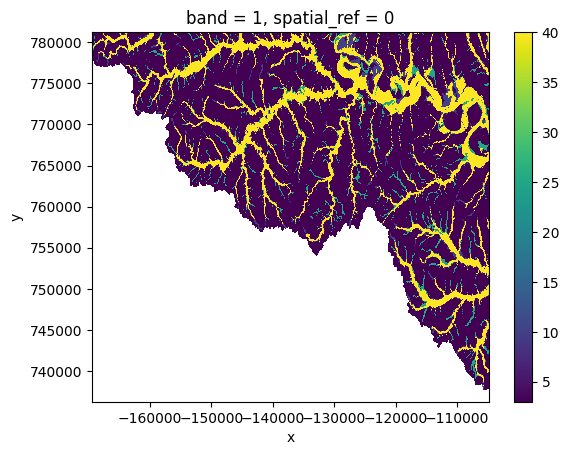

In [9]:
agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark, 
                                                     comparison_function='cantor')

agreement_map.plot()

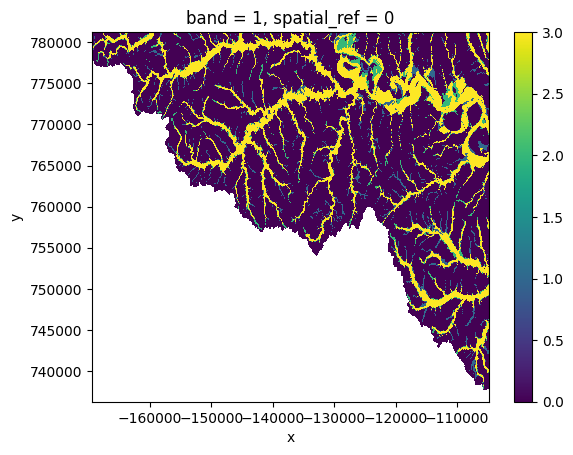

In [10]:
agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark, 
                                                     comparison_function='pairing_dict',
                                                     allow_candidate_values=[1, 2],
                                                     allow_benchmark_values=[0, 2])

agreement_map.plot()

#### Registration of Custom Functions

In this case we register the arbitrary pairing function `multiply` with the name "multi" and then vectorize it.  `Multiply` can also be passed in as a function in the `comparison_function` argument

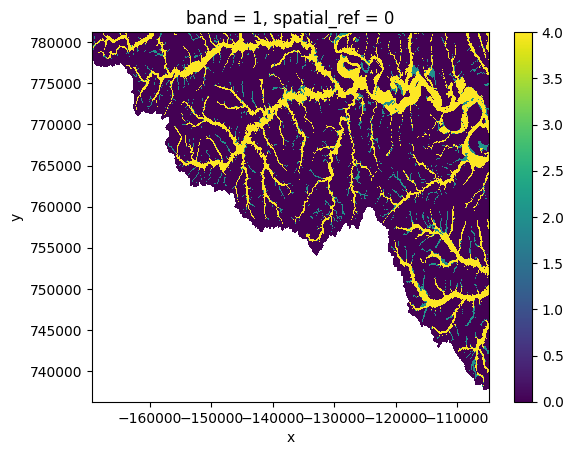

In [11]:
from gval import Comparison
from numbers import Number

@Comparison.register_function(name='multi', vectorize_func=True)
def multiply(c: Number, b: Number) -> Number:
    return c * b

agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark, 
                                                     comparison_function="multi")

agreement_map.plot()

A user can also pick which candidate values or benchmark values to use by providing lists to the `allow_candidate_values` and `allow_benchmark_values` arguments.  Finally, a user can choose to write nodata to unmasked datasets with the `nodata` value, or to masked/scaled datasets with `encode_nodata`. 

### Cross-tabulation Table

When computing a crosstab table a user may create an allow list for candidate/benchmark values just as done in  the compute agreement map method.  They may also exclude a nodata value with `exclude_value` in the case that `mask_and_scale` is not applied when loading the original data files.

In [12]:
crosstab_table_allow = candidate.gval.compute_crosstab(benchmark,
                                                       allow_benchmark_values=[0, 2],
                                                       allow_candidate_values=[2])

In [13]:
crosstab_table_allow

,band,candidate_values,benchmark_values,counts
0,1,2.0,0.0,544392.0
1,1,2.0,2.0,2624301.0


#### Metric Table

Although all categorical metrics are computed by default if no argument is provided, `metrics` can also take a list of the desired metrics and will only return metrics in this list.

In [14]:
metrics = []
metric_table_select = crosstab_table.gval.compute_metrics(negative_categories= [0, 1],
                                                          positive_categories = [2],
                                                          metrics=['true_positive_rate', 'prevalence'])

In [15]:
metric_table_select

,band,fn,fp,tn,tp,true_positive_rate,prevalence
0,1,639227.0,512277.0,10345720.0,2473405.0,0.794635,0.213711


Just like registering pairing functions, you are able to register a metric function on both a method and a class of funcitons.  Below is registering a metric funciton:

In [16]:
from gval import CatStats

@CatStats.register_function(name="error_balance", vectorize_func=True)
def error_balance(fp: Number, fn: Number) -> float:
    return fp / fn

The following is registering a class of metric functions, (the name will be the respective method name)

In [17]:
@CatStats.register_function_class(vectorize_func=True)
class MetricFunctions:
    
    @staticmethod
    def arbitrary1(tp: Number, tn: Number) -> float:
        return tp + tn
    
    @staticmethod
    def arbitrary2(tp: Number, tn: Number) -> float:
        return tp - tn

All of these functions are now callable as metrics:

In [18]:
metric_table_register = crosstab_table.gval.compute_metrics(negative_categories= None,
                                                            positive_categories = [2],
                                                            metrics=['error_balance', 'arbitrary1', 'arbitrary2'])

In [19]:
metric_table_register

,band,fn,fp,tp,error_balance,tn
0,1,639227.0,512277.0,2473405.0,0.801401,NaN


Finally there will be cases where a candidate map and/or a benchmark map will not have any negative encoding, which disallows the assumption of a true negative.  Regardless, statistics can still be run aon all funcitons not requiring the true negative parameter.  This is done by supplying None in the `negative_categories` argument:

In [20]:
metric_table_no_negative_enc = crosstab_table.gval.compute_metrics(negative_categories= None,
                                                                   positive_categories = [2],
                                                                   metrics='all')

In [21]:
metric_table_no_negative_enc

,band,fn,fp,tp,critical_success_index,f_score,false_discovery_rate,false_negative_rate,fowlkes_mallows_index,positive_predictive_value,true_positive_rate,error_balance,tn
0,1,639227.0,512277.0,2473405.0,0.682336,0.811177,0.171578,0.205365,0.811352,0.828422,0.794635,0.801401,NaN


In [32]:
import numpy as np
metric_table_no_negative_enc.insert(loc=metric_table_no_negative_enc.columns.get_loc("tp") +1, column="tx", value=np.nan)

In [33]:
metric_table_no_negative_enc

,band,fn,fp,tx,tp,critical_success_index,f_score,false_discovery_rate,false_negative_rate,fowlkes_mallows_index,positive_predictive_value,true_positive_rate,error_balance,tn
0,1,639227.0,512277.0,NaN,2473405.0,0.682336,0.811177,0.171578,0.205365,0.811352,0.828422,0.794635,0.801401,NaN


## Save Output

Finally, a user can take the results and save them to a directory of their choice.  The following is an example of saving the agreement map and then the metric table:

In [22]:
# output agreement map
agreement_file = 'agreement_map.tif'
metric_file = 'metric_file.csv'

agreement_map.rio.to_raster(agreement_file)
metric_table.to_csv(metric_file)